In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.metrics import ConfusionMatrixDisplay
import optuna 

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

In [3]:
data = pd.read_csv("/kaggle/input/porter-delivery-time-estimation/dataset.csv")
data

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,df263d996281d984952c07998dc54358,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,f0ade77b43923b38237db569b016ba25,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,f0ade77b43923b38237db569b016ba25,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,f0ade77b43923b38237db569b016ba25,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,f0ade77b43923b38237db569b016ba25,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197423,1.0,2015-02-17 00:19:41,2015-02-17 01:24:48,a914ecef9c12ffdb9bede64bb703d877,fast,4.0,3,1389,3,345,649,17.0,17.0,23.0
197424,1.0,2015-02-13 00:01:59,2015-02-13 00:58:22,a914ecef9c12ffdb9bede64bb703d877,fast,4.0,6,3010,4,405,825,12.0,11.0,14.0
197425,1.0,2015-01-24 04:46:08,2015-01-24 05:36:16,a914ecef9c12ffdb9bede64bb703d877,fast,4.0,5,1836,3,300,399,39.0,41.0,40.0
197426,1.0,2015-02-01 18:18:15,2015-02-01 19:23:22,c81e155d85dae5430a8cee6f2242e82c,sandwich,1.0,1,1175,1,535,535,7.0,7.0,12.0


In [4]:
data["store_primary_category"].unique()

array(['american', 'mexican', nan, 'indian', 'italian', 'sandwich',
       'thai', 'cafe', 'salad', 'pizza', 'chinese', 'singaporean',
       'burger', 'breakfast', 'mediterranean', 'japanese', 'greek',
       'catering', 'filipino', 'convenience-store', 'other', 'korean',
       'vegan', 'asian', 'barbecue', 'fast', 'dessert', 'smoothie',
       'seafood', 'vietnamese', 'cajun', 'steak', 'middle-eastern',
       'soup', 'vegetarian', 'persian', 'nepalese', 'sushi',
       'latin-american', 'hawaiian', 'chocolate', 'burmese', 'british',
       'pasta', 'alcohol', 'dim-sum', 'peruvian', 'turkish', 'malaysian',
       'ethiopian', 'afghan', 'bubble-tea', 'german', 'french',
       'caribbean', 'gluten-free', 'comfort-food', 'gastropub',
       'pakistani', 'moroccan', 'spanish', 'southern', 'tapas', 'russian',
       'brazilian', 'european', 'cheese', 'african', 'argentine',
       'kosher', 'irish', 'lebanese', 'belgian', 'indonesian',
       'alcohol-plus-food'], dtype=object)

In [5]:
data["actual_delivery_time"] = pd.to_datetime(data["actual_delivery_time"])
data["created_at"]=pd.to_datetime(data["created_at"])

In [6]:
data

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,df263d996281d984952c07998dc54358,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,f0ade77b43923b38237db569b016ba25,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,f0ade77b43923b38237db569b016ba25,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,f0ade77b43923b38237db569b016ba25,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,f0ade77b43923b38237db569b016ba25,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197423,1.0,2015-02-17 00:19:41,2015-02-17 01:24:48,a914ecef9c12ffdb9bede64bb703d877,fast,4.0,3,1389,3,345,649,17.0,17.0,23.0
197424,1.0,2015-02-13 00:01:59,2015-02-13 00:58:22,a914ecef9c12ffdb9bede64bb703d877,fast,4.0,6,3010,4,405,825,12.0,11.0,14.0
197425,1.0,2015-01-24 04:46:08,2015-01-24 05:36:16,a914ecef9c12ffdb9bede64bb703d877,fast,4.0,5,1836,3,300,399,39.0,41.0,40.0
197426,1.0,2015-02-01 18:18:15,2015-02-01 19:23:22,c81e155d85dae5430a8cee6f2242e82c,sandwich,1.0,1,1175,1,535,535,7.0,7.0,12.0


In [7]:
data["delivery_time"] = data["actual_delivery_time"] - data["created_at"] 

In [8]:
data["delivery_time"] = pd.to_timedelta(data['delivery_time']).dt.total_seconds() / 60

In [9]:
data

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,delivery_time
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,df263d996281d984952c07998dc54358,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,62.983333
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,f0ade77b43923b38237db569b016ba25,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,67.066667
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,f0ade77b43923b38237db569b016ba25,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,29.683333
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,f0ade77b43923b38237db569b016ba25,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,51.250000
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,f0ade77b43923b38237db569b016ba25,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,39.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197423,1.0,2015-02-17 00:19:41,2015-02-17 01:24:48,a914ecef9c12ffdb9bede64bb703d877,fast,4.0,3,1389,3,345,649,17.0,17.0,23.0,65.116667
197424,1.0,2015-02-13 00:01:59,2015-02-13 00:58:22,a914ecef9c12ffdb9bede64bb703d877,fast,4.0,6,3010,4,405,825,12.0,11.0,14.0,56.383333
197425,1.0,2015-01-24 04:46:08,2015-01-24 05:36:16,a914ecef9c12ffdb9bede64bb703d877,fast,4.0,5,1836,3,300,399,39.0,41.0,40.0,50.133333
197426,1.0,2015-02-01 18:18:15,2015-02-01 19:23:22,c81e155d85dae5430a8cee6f2242e82c,sandwich,1.0,1,1175,1,535,535,7.0,7.0,12.0,65.116667


In [10]:
t_data = data.copy()
t_data = t_data.drop(["store_primary_category", "store_id"], axis="columns")

In [11]:
corr = t_data.corr(method="pearson")
corr

,market_id,created_at,actual_delivery_time,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,delivery_time
market_id,1.000000,0.039242,-0.000216,-0.021895,-0.006855,-0.016237,0.002557,-0.000150,-0.004921,0.069752,0.060488,0.063754,-0.005784
created_at,0.039242,1.000000,0.007436,0.005304,-0.006291,-0.009758,-0.005827,0.001216,-0.000307,0.037097,-0.035425,0.048064,-0.028321
actual_delivery_time,-0.000216,0.007436,1.000000,0.000723,-0.001543,-0.000566,-0.001264,0.001986,0.000545,-0.005328,-0.005172,-0.005894,-0.000602
order_protocol,-0.021895,0.005304,0.000723,1.000000,0.008790,-0.053623,-0.023342,-0.045421,-0.090960,0.145022,0.149584,0.134895,-0.006660
total_items,-0.006855,-0.006291,-0.001543,0.008790,1.000000,0.558067,0.763912,-0.393149,-0.058233,0.031732,0.028602,0.034380,0.004905
subtotal,-0.016237,-0.009758,-0.000566,-0.053623,0.558067,1.000000,0.681101,0.037038,0.505547,0.130831,0.125566,0.130106,0.011200
num_distinct_items,0.002557,-0.005827,-0.001264,-0.023342,0.763912,0.681101,1.000000,-0.448739,0.041871,0.065943,0.060638,0.067800,0.006741
min_item_price,-0.000150,0.001216,0.001986,-0.045421,-0.393149,0.037038,-0.448739,1.000000,0.545484,0.042368,0.043881,0.041002,0.004762
max_item_price,-0.004921,-0.000307,0.000545,-0.090960,-0.058233,0.505547,0.041871,0.545484,1.000000,0.133113,0.131005,0.130676,0.009409
total_onshift_partners,0.069752,0.037097,-0.005328,0.145022,0.031732,0.130831,0.065943,0.042368,0.133113,1.000000,0.943789,0.936122,0.046972


([<matplotlib.axis.YTick at 0x7fe18beeb8e0>,
 [Text(0, 0, 'market_id'),
  Text(0, 1, 'created_at'),
  Text(0, 2, 'actual_delivery_time'),
  Text(0, 3, 'order_protocol'),
  Text(0, 4, 'total_items'),
  Text(0, 5, 'subtotal'),
  Text(0, 6, 'num_distinct_items'),
  Text(0, 7, 'min_item_price'),
  Text(0, 8, 'max_item_price'),
  Text(0, 9, 'total_onshift_partners'),
  Text(0, 10, 'total_busy_partners'),
  Text(0, 11, 'total_outstanding_orders'),
  Text(0, 12, 'delivery_time')])

<Figure size 800x800 with 0 Axes>

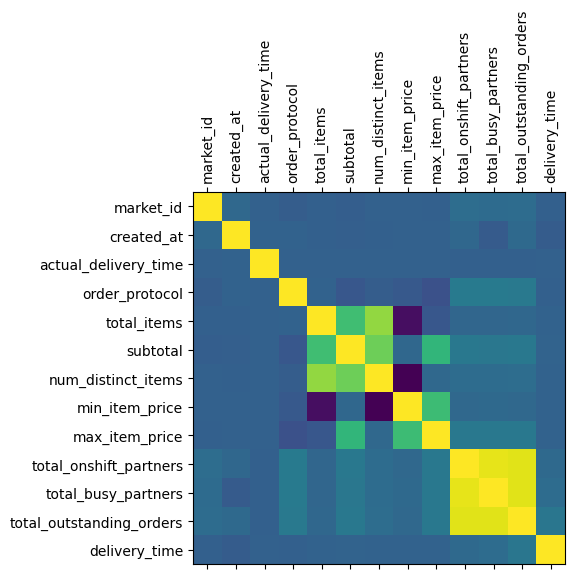

In [12]:
plt.figure(figsize=(8, 8))
plt.matshow(corr)

plt.xticks(range(len(t_data.columns)), t_data.columns, rotation=90)  
plt.yticks(range(len(t_data.columns)), t_data.columns)

In [13]:
data.isnull().sum()

market_id                     987
created_at                      0
actual_delivery_time            7
store_id                        0
store_primary_category       4760
order_protocol                995
total_items                     0
subtotal                        0
num_distinct_items              0
min_item_price                  0
max_item_price                  0
total_onshift_partners      16262
total_busy_partners         16262
total_outstanding_orders    16262
delivery_time                   7
dtype: int64

In [14]:
data.dtypes

market_id                          float64
created_at                  datetime64[ns]
actual_delivery_time        datetime64[ns]
store_id                            object
store_primary_category              object
order_protocol                     float64
total_items                          int64
subtotal                             int64
num_distinct_items                   int64
min_item_price                       int64
max_item_price                       int64
total_onshift_partners             float64
total_busy_partners                float64
total_outstanding_orders           float64
delivery_time                      float64
dtype: object

In [15]:
x = data.drop(["store_id", "market_id", "created_at", "actual_delivery_time", "delivery_time"], axis="columns")
y = data["delivery_time"]
y = y.fillna(y.median())

In [16]:
x = x.head(10000)
y = y.head(10000)

In [17]:
x.isnull().sum()

store_primary_category      275
order_protocol               50
total_items                   0
subtotal                      0
num_distinct_items            0
min_item_price                0
max_item_price                0
total_onshift_partners      780
total_busy_partners         780
total_outstanding_orders    780
dtype: int64

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [19]:
cat_columns = ["store_primary_category"]

num_columns = ["order_protocol", "total_items", "subtotal", "num_distinct_items", 
                   "min_item_price", "max_item_price", "total_onshift_partners", 
                   "total_busy_partners", "total_outstanding_orders"]


In [60]:
def optimization(trial):
    
    x = data.drop(["store_id", "market_id", "created_at", "actual_delivery_time", "delivery_time"], axis="columns")
    y = data["delivery_time"]
    y = y.fillna(y.median())

    
    x = x.head(10000)
    y = y.head(10000)
    
    x_sample, x_test, y_sample, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    
    model_name = trial.suggest_categorical("model_name", ["SVR", "KNeighborsRegressor", "LinearRegression"])
    
    if model_name == "SVR":
        gamma = trial.suggest_categorical("gamma", ["scale", "auto"])
        kernel = trial.suggest_categorical("kernel", ["linear", "rbf", "poly"])
        degree = trial.suggest_int('degree', 1, 5)
        
        regr = SVR(
            gamma=gamma,
            kernel=kernel,
            degree=degree    
        )
        
        
    elif model_name == "RandomForestRegressor":
        n_estimators = trial.suggest_int("n_estimators", 10, 100)
        max_depth = trial.suggest_int("max_depth", 1, 5)
        criterion = trial.suggest_categorical("criterion", ["squared_error", "absolute_error"])
        
        regr = RandomForestRegressor(
            n_estimators = n_estimators,
            max_depth = max_depth,
            criterion = criterion
        )
        
        
    elif model_name == "KNeighborsRegressor":
        weights = trial.suggest_categorical("weights", ["uniform", "distance"])
        n_neighbors = trial.suggest_int("n_neighbors", 3, 9)
        regr = KNeighborsRegressor(weights=weights, n_neighbors=n_neighbors, n_jobs=-1)
        
    elif model_name == "LinearRegression":
        fit_intercept = trial.suggest_categorical("fit_intercept", [True, False])
        copy_X = trial.suggest_categorical("copy_X", [True, False])
        n_jobs = trial.suggest_int("n_jobs", 1, 5)
        
        regr = LinearRegression(
            fit_intercept = fit_intercept,
            copy_X = copy_X,
            n_jobs = n_jobs
        )
        
    cat_columns = ["store_primary_category"]
    num_columns = ["order_protocol", "total_items", "subtotal", "num_distinct_items", 
                   "min_item_price", "max_item_price", "total_onshift_partners", 
                   "total_busy_partners", "total_outstanding_orders"]    
    
    cat_pipeline = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy='most_frequent')),
        ("encoder", OneHotEncoder(handle_unknown='ignore'))
    ])

    num_pipeline = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy='mean')),
        ("scaler", MinMaxScaler())
    ])

    preprocessor = ColumnTransformer(transformers=[
        ('cat', cat_pipeline, cat_columns),
        ('num', num_pipeline, num_columns)
    ])     
    
    best_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", regr)
    ])
        
    
    best_model.fit(x_sample, y_sample)
    y_preds = best_model.predict(x_test)
    mse = mean_squared_error(y_test, y_preds)
    
    return mse


In [61]:
study = optuna.create_study(direction="minimize")
study.optimize(optimization, n_trials=20)

[I 2024-10-09 09:45:10,151] A new study created in memory with name: no-name-368272f1-c57a-4d0a-8aae-0b8bb41acfb8
[I 2024-10-09 09:45:10,232] Trial 0 finished with value: 7031.379305753471 and parameters: {'model_name': 'LinearRegression', 'fit_intercept': True, 'copy_X': True, 'n_jobs': 2}. Best is trial 0 with value: 7031.379305753471.
[I 2024-10-09 09:45:14,200] Trial 1 finished with value: 315.83996444312663 and parameters: {'model_name': 'SVR', 'gamma': 'auto', 'kernel': 'linear', 'degree': 3}. Best is trial 1 with value: 315.83996444312663.
[I 2024-10-09 09:45:18,214] Trial 2 finished with value: 315.83996444312663 and parameters: {'model_name': 'SVR', 'gamma': 'scale', 'kernel': 'linear', 'degree': 4}. Best is trial 1 with value: 315.83996444312663.
[I 2024-10-09 09:45:19,197] Trial 3 finished with value: 998851.907729832 and parameters: {'model_name': 'KNeighborsRegressor', 'weights': 'distance', 'n_neighbors': 5}. Best is trial 1 with value: 315.83996444312663.
[I 2024-10-09 0

In [63]:
res = study.best_value
res = np.sqrt(res)
print(f"Average loss is: {round(res, 2)}")

Average loss is: 17.77


In [64]:
study.best_params

{'model_name': 'SVR', 'gamma': 'auto', 'kernel': 'linear', 'degree': 3}

In [65]:
params = study.best_params

In [66]:
model = SVR(kernel=params["kernel"],
               gamma=params["gamma"], 
               degree=params["degree"])

In [67]:
# firstly a pipeline for categorical columns handling with all necessary features ("imputer", "encoder")

cat_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='most_frequent')),  
    ("encoder", OneHotEncoder(handle_unknown='ignore'))   
])

# then a pipeline for numerical columns handling with all necessary features ("imputer", "scaler")

num_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='mean')),  
    ("scaler", MinMaxScaler())                    
])

# combine pipelines in a preprocessor

preprocessor = ColumnTransformer(transformers=[
    ('cat', cat_pipeline, cat_columns),    
    ('num', num_pipeline, num_columns)      
])


best_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", model)
])

In [68]:
best_model.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['store_primary_category']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['order_protocol',
                                                   'total_items', 'subtotal',
                                                   'num_distinct_items',
                                                   'min_item_price',
                                                   'max_item_price',
                                                   'total_onshift_partners',
                                                   'total_busy_partners',
                                                   'total_outstanding_orders'])])),
                ('model', SVR(gamma='auto', kernel='linear'))])

In [45]:
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['store_primary_category']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['order_protocol',
                                                   'total_items', 'subtotal',
                                                   'num_distinct_items',
                                                   'min_item_price',
                                                   'max_item_price',
                                                   'total_onshift_partners',
                                                   'total_busy_partners',
                                                   'total_outstanding_orders'])])),
                ('model', SVR(kernel='linear'))])

In [69]:
best_model.score(x_test, y_test)

0.09406853853245944

In [70]:
y_preds = best_model.predict(x_test)

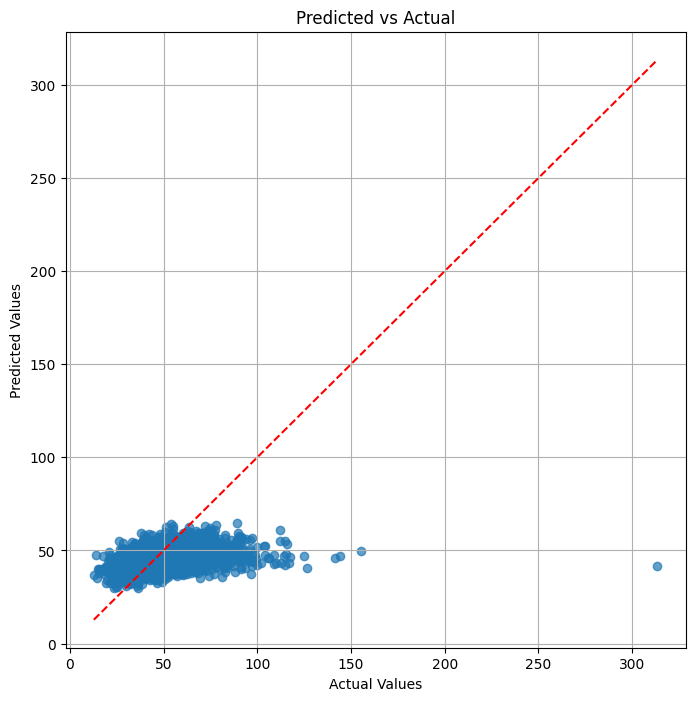

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_preds, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('Predicted vs Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid()
plt.show()


# x axis for actual values 
# y axis for predictions

# points show how often they cross each other (being right)